In [1]:
import gensim
import subprocess
import re
import numpy as np
import time
import nltk
import os
import json
import collections
import time
import matplotlib.pyplot as plt
import itertools
from gensim.utils import simple_preprocess
from sklearn.model_selection import train_test_split
from IPython.display import Image
from keras.utils.vis_utils import plot_model
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error
nltk.download('stopwords')
nltk.download('punkt')

Using TensorFlow backend.
/home/kirov/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/kirov/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/kirov/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/kirov/.local/lib/python3.7/site-packages/tensorflow/python/fra

True

### Problema: Determinar la veracidad de tweets, utilizando clasificación
- Implementar un clasificador de post de tweets para validar su veracidad.
- Para esto se utilizará redes neuronales y el árbol de  propagación de los tweets.


In [2]:
#Image("/home/eprovidel/Text_Mining/Proyecto/modelos.png")

In [3]:
import keras
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)
keras.backend.set_session(sess)

# Parte 1: Procesamiento de datos y funcionalidades

## Parte 1.1: Cargar tweets para generar datos de entrenamiento

In [4]:
words_not_in_model = list()
def computeDocumentAWE(docText, _model, _model_vocab, _emb_size):
    """
    Calcula el AWE del texto recibido en el parámetro docText.
    La variable docSum almacena la suma de los embeddings de cada
    palabra w en docText. Luego esta suma se divide por el total
    de n palabras consideradas.
    
    Se considero una palabra para el cálculo sólo si esta pertenece
    al vocabulario del modelo. Si no, no es considerada en la suma 
    ni tampoco en el calculo de n.
    """    
    docSum = np.zeros(_emb_size)
    n = 0
    
    ####
    ## AWE = 1/n * Sum w_embedding, para cada w en docText
    ####
    
    normalizedDocText = normalizarTexto(docText)
    
    for w in normalizedDocText:
        ## Se descartan palabras que no están en el modelo de embeddings (vocabulario)
        if w in _model_vocab:
            n = n + 1
            w_embedding = _model[w]
            docSum = docSum + w_embedding
        else:
            words_not_in_model.append(w)

    return docSum / n if n > 0 else docSum    

In [5]:
def normalizarTexto(docText):
    # En gensim.utils, pasa a minúsculas, descarta palabras muy grandes o muy pequeñas.
    return simple_preprocess(docText)

In [6]:
def parseTwitterTree(tree_file):
    tree_data = list()
    for line in tree_file:
        _, second_part = line.split('->')
        second_part = second_part.rstrip()
        second_part = second_part.replace("'", "\"")
        tree_data.append(json.loads(second_part))     
    return tree_data

In [7]:
### Obtener diccionario con todos los posts
all_posts = {}
all_text = {}
#for file in os.listdir('/home/kirov/dataset/post'):
for file in os.listdir('./post'):    
    if file.endswith(".json"):        
        try:        
            with open(os.path.join('./post', file), 'r') as f:
                tweet_id  = os.path.splitext(file)[0]
                tweet_dic = json.load(f)
                all_posts[tweet_id] = tweet_dic
                

        except:
            pass
        

### Obtener ids de tweets etiquetados
labels = {}
with open('label.txt') as label_f:
    for label_line in label_f:
        
        label, tweet_id = label_line.split(':')
        tweet_id = tweet_id.rstrip()
        labels[tweet_id] = label

print("Tweets etiquetados      : ", len(labels))        

seqs_lens = []
labeled_posts = {}
number_of_tweets = 0
number_of_retweets = 0
number_of_invalid_tweets = 0
no_in_data = 0
for tweet_id in labels.keys():
    try:
        if tweet_id in all_posts:
            tree_path = os.path.join('./tree', tweet_id + '.txt')
            with open(tree_path) as tree_file:
                tree_data = parseTwitterTree(tree_file)
                ### Remover retweets                
                first = tree_data[0]
                without_rt = list(filter(lambda t: t[1] != tweet_id, tree_data))
                number_of_retweets = number_of_retweets + (len(tree_data) - len(without_rt))
                only_valid = list(filter(lambda t: t[1] in all_posts, without_rt))
                number_of_invalid_tweets = number_of_invalid_tweets + (len(without_rt) - len(only_valid))
                seqs_lens.append(len(only_valid))
                labeled_posts[tweet_id] = (labels[tweet_id], [first] + only_valid)
                number_of_tweets = number_of_tweets + 1 
        else:
             no_in_data = no_in_data + 1 
        
    except Exception as e:
        print(e)             
        
        
print("no_in_data              : ", no_in_data) ## están etiquetados, pero no en los post
print("number_of_tweets        : ", number_of_tweets)        
print("all_posts               : ", len(all_posts))
print("number_of_retweets      : ", number_of_retweets) ## En árbol de propagación
print("number_of_invalid_tweets: ", number_of_invalid_tweets) ## En árbol de propagación


Tweets etiquetados      :  818
no_in_data              :  65
number_of_tweets        :  753
all_posts               :  21741
number_of_retweets      :  297301
number_of_invalid_tweets:  6432


**Importante:** Importan sólo los datos etiquetados que se conocen y que no son retweets de cada árbol de progación.

## Parte 1.2: Aplicar AWE a cada tweet del arbol

In [8]:
## Cada palabra tiene un embedding que viene del modelo
## Se calcula AWE para cada post del árbol de propagación (lista de propagación que el primer elemento es el tweet original)
def computeTreeAWE(tree, _model, _model_vocab, _emb_size):
    return list(map(lambda t: [t[0], computeDocumentAWE(all_posts[t[1]]['text'],
                                                        _model, _model_vocab, _emb_size), t[2]], tree))

[17 19 33 23 28 32 22 22 22 22 16 17 15 18 22 15 19 16 21 11  9  8 10 14
  7  9  6  7  8  7 11  6  7  5  5 10  2  3  5  5  1  7  3  7  3  1  3  7
  4  5  2  3  5  1  1  4  1  4  5  0  3  0  1  4  2  3  4  2  1  2  1  1
  4  2  2  4  1  1  5  1  2  2  1  1  1  3  3  0  3  1  1  2  1  2  2  0
  1  1  1  1  0  0  1  0  1  1  0  1  2  1  1  0  0  1  0  1  0  1  0  0
  0  1  1  1  2  0  0  1  0  2  1  1  0  0  1  1  0  0  1  0  0  0  0  0
  1  0  1  0  1  0  0  0  0  0  1  1  0  0  2  1  0  0  1  1  1  0  0  0
  0  0  0  0  0  1  0  0  0  0  0  0  0  0  1  1  0  0  1  0  0  0  0  0
  0  0  0  0  1  1  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0
  0  0  0  0  0  0  0  0  1  0  0  0  1  1  0  0  1  0  0  0  0  0  0  1
  0  1  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0

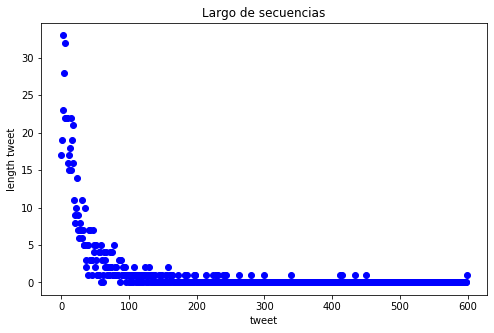

In [9]:
# Categorias: true, false, unverified, non-rumor
categories = ['true', 'false', 'unverified', 'non-rumor']
num_categories = len(categories)

#entrega un vector one-hot de la categoria, de largo 4 (por el número de categorias)
def to_category_vector(category):
    vector = np.zeros(len(categories)).astype(np.float32)
    
    for i in range(len(categories)):
        if categories[i] == category:
            vector[i] = 1.0
            break
    
    return vector

#La red neuronal necesita un tamaño fijo para la secuencia (datos de entrada)
#¿Que largo de secuencia utilizar?
counts = np.bincount(seqs_lens) ## seqs_len sólo de los 753
print(counts)
mode_seq_len = np.argmax(counts)
mean_seq_len = int(np.mean(seqs_lens))
min__seq_len = min(seqs_lens)
max__seq_len = max(seqs_lens) 
## luego se hace padding

print("seqs_lens   : ", seqs_lens)
print("min__seq_len: ", min__seq_len)
print("max__seq_len: ", max__seq_len)
print("mean_seq_len: ", mean_seq_len)
print("mode_seq_len: ", mode_seq_len )

plt.close('all')
plt.figure(figsize=(8,5))
plt.plot(counts,'bo')
plt.title("Largo de secuencias")
plt.xlabel("tweet")
plt.ylabel("length tweet")
plt.savefig('/home/kirov/plots/plt_largoSecuenciasGRU')

tree_max_num_seq = mean_seq_len

In [10]:
## padding al final, con empty
def padAWE(empty, max_num, seq):
    from itertools import repeat
    seq.extend(repeat(empty, max_num - len(seq)))
    return seq

In [11]:
## 
def generate_w2v_variant(_model, _model_vocab, _emb_size):
    
    empty_awe = np.zeros(_emb_size)
    ## Calcula AWE de cada árbol
    labeled_posts_awe = { k: (v[0], computeTreeAWE(v[1], _model, _model_vocab, _emb_size)) for k, v in labeled_posts.items() }
    ## Realiza padding a las secuencias
    padded_labeled_posts_awe = {k: (v[0], padAWE(empty_awe, tree_max_num_seq, v[1])) for k, v in labeled_posts_awe.items()}

    #Genera los datos X e Y para alimentar el modelo de red neuronal
    #Inicialmente con ceros y con la forma adecuada.
    X = np.zeros(shape=(number_of_tweets, tree_max_num_seq, _emb_size)).astype(np.float32)
    Y = np.zeros(shape=(number_of_tweets, num_categories)).astype(np.float32)

    # Asigna al vector X los datos correspondientes
    for idx, (tweet_id, tweet_data) in enumerate(list(padded_labeled_posts_awe.items())):
        for jdx, tweet_d in enumerate(tweet_data[1]):
            ### tweet_d = [uid, tweet_awe, time]
            if jdx == tree_max_num_seq:
                break            
            else:            
                X[idx, jdx, :] = tweet_d[1]

    # Asigna al vector Y los datos correspondientes            
    for idx, (tweet_id, tweet_data) in enumerate(list(padded_labeled_posts_awe.items())):
        Y[idx, :] = to_category_vector(tweet_data[0])

    print(np.shape(X))
    print(np.shape(Y))
    return X, Y

## Parte 1.3: Modelo Conv1D

In [24]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, LSTM, GRU, Bidirectional, Conv1D, Flatten, MaxPooling1D


### tensorflow OMP: Error #15
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'


def create_model_Conv1D(
            _tree_max_num_seq,
            _emb_size,
            _num_categories,
            _units = 200,
            _dropout = 0.3,
            _kernel_size = 1):
       
        model = Sequential()
        model.add(Conv1D(_units, _kernel_size, activation='relu', input_shape=(_tree_max_num_seq, _emb_size)))
        model.add(MaxPooling1D())
        model.add(Conv1D(_units, _kernel_size, activation='relu'))
        model.add(MaxPooling1D())
        model.add(Flatten())
        model.add(Dropout(_dropout))
        model.add(Dense(_num_categories))
        model.add(Activation('softmax'))
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        return model    
    
    
    


## Parte 1.4: Funciones para graficar

In [25]:
def graphic_data(dataX, dataY, labels, title, x_label, y_label, x_min, y_min, x_max, y_max=0):
    plt.close('all') 
    plt.title(title)
    for d in dataY:
        plt.ylim(y_min,y_max)
        plt.xlim(x_min,x_max)
        plt.plot(d)
        plt.xlabel(x_label)
        plt.ylabel(y_label)
        plt.xticks(dataX)
    plt.legend(labels, loc='upper right')
    plt.savefig('/home/kirov/plots/plt_grapicDataConv1D')
    plt.show()

In [26]:
#ref: https://scikit-learn.org/stable/auto_examples/model_selection/plot_cv_indices.html#sphx-glr-auto-examples-model-selection-plot-cv-indices-py
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(6,6))
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')


    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.savefig('/home/kirov/plots/plt_matrizConv1D')

In [27]:
def plot_conf_matrix(y_true, y_pred, _title):
    y_t = y_true.argmax(1)#Yw2v50_full.argmax(1)
    y_p = y_pred.argmax(1)#Yw2v50_predict.argmax(1)
    conf_matrix = confusion_matrix(y_t, y_p)
    class_names = ['true', 'false', 'unverified', 'non-rumor']
    # Plot confusion matrix
    plt.figure(figsize=(5,5))
    plot_confusion_matrix(conf_matrix, classes=class_names, normalize=False,
                      title=_title,cmap=plt.cm.Greens) 

## Parte 1.5: Entrenamiento y Pruebas

In [28]:
epochs = 50 #200
units_final = [128,256] #[8,16, 32, 64, 128, 256, 512, 1024]

In [29]:
#dummy_model = create_model_LSTM(10, 128)
#dummy_model = create_model_GRU(10,10,128)
#dummy_model.summary()

In [30]:
def perform_kfold_validation(X, Y, _emb_size, k = 5, _verbose = 0):
    seed = 7
    results_score = []
    results_acc   = []
    results_time  = []
    kfold = StratifiedKFold(n_splits=k, shuffle=True, random_state=seed)
    y_pred = []

    for j, (train_idx, test_idx) in enumerate(kfold.split(X, Y.argmax(1))):
        print('\nFold ',j)
        print("\nlen train index: %s" % len(train_idx))       
        print("len test index: %s" % len(test_idx))
        X_train_cv = X[train_idx]
        Y_train_cv = Y[train_idx]
        X_test_cv  = X[test_idx]
        Y_test_cv  = Y[test_idx]
        
        #crear modelo GRU
                
        model = create_model_Conv1D(tree_max_num_seq,_emb_size,num_categories)
        
     
        start_time = time.time()
        model.fit(X_train_cv, Y_train_cv, batch_size=128, epochs=200, verbose= _verbose)     ## entrenamos
        score, acc = model.evaluate(X_test_cv, Y_test_cv, batch_size=128,verbose= _verbose) ## evaluamos /acc: accuracy
        end_time = time.time()

        print('Score: %1.4f' % score)
        print('Accuracy: %1.4f' % acc)  
        print('time: %1.4f' % (end_time - start_time))
        results_score.append(score)
        results_acc.append(acc)
        results_time.append((end_time - start_time))
    
    return results_score, results_acc, results_time

In [31]:
### https://datascience.stackexchange.com/questions/20413/clarification-on-the-keras-recurrent-unit-cell
def perform_final_validation(X, Y, X_validate, Y_validate, _emb_size, units=[8,16, 32, 64, 128, 200], _epochs=200, _verbose=1):
    h_units_score = []
    h_units_acc   = []
    history = []
    all_models = []
    for unit_size in (units): #[8,16, 32, 64, 128, 200, 512, 1024]
        print("########################")
        print("## UNIT SIZE ", unit_size)
        
        #crear modelo final Conv1D
                
        final_model = create_model_Conv1D(tree_max_num_seq,_emb_size,num_categories,_units = unit_size)

        
        final_model.summary()
        
        history.append(final_model.fit(X, Y, batch_size=128, epochs=_epochs, verbose=_verbose))
        score, acc = final_model.evaluate(X_validate, Y_validate, batch_size=128)
        h_units_score.append(score)
        h_units_acc.append(acc)
        all_models.append(final_model)
    return h_units_score, h_units_acc,history, all_models

## Parte 2: Modelo Conv1D

### Modelo word2vec específico, Conv1D

### Creando los vectores
Se utilizan todos los tweets etiquetados como el universo de documentos, para crear el modelo de embedding w2v

In [32]:
# build vocabulary and train model
w2v50_emb_size = 50
WINDOW = 5
W2V_EPOCHS = 50
BATCH_SIZE = 128

documents = []
for k, v in labeled_posts.items():
    for t in v[1]:
        #print(t[1]) ## sera porque algunos text estan vacios????
        # Dejar todo en lowercase
        documents.append(simple_preprocess(all_posts[t[1]]['text']))

In [33]:

w2v50_model = gensim.models.word2vec.Word2Vec(
 documents,
 size=w2v50_emb_size,
 window=WINDOW,
 min_count=2,
 workers=4,
 iter=W2V_EPOCHS
)

#Train model
w2v50_model.train(documents, total_examples=len(documents), epochs=w2v50_model.epochs)

(14799734, 18536800)

In [34]:
w2v50_model_vocab = w2v50_model.wv.vocab

In [35]:
Xw2v50_full, Yw2v50_full = generate_w2v_variant(w2v50_model, w2v50_model_vocab, w2v50_emb_size)
Xw2v50, X_1w2v50, Yw2v50, Y_1w2v50 = train_test_split(Xw2v50_full, Yw2v50_full, test_size=0.15)
perform_kfold_validation(Xw2v50, Yw2v50, w2v50_emb_size)
#perform_final_validation(Xw2v50, Yw2v50, X_1, Y_1, w2v50_emb_size) #X_1 y Y_1 Es el tamaño del set de testing
perform_final_validation(Xw2v50, Yw2v50, X_1w2v50, Y_1w2v50, w2v50_emb_size)

/home/kirov/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


(753, 36, 50)
(753, 4)

Fold  0

len train index: 512
len test index: 128


Score: 1.1844
Accuracy: 0.7812
time: 48.3623

Fold  1

len train index: 512
len test index: 128
Score: 1.4535
Accuracy: 0.6875
time: 43.6571

Fold  2

len train index: 512
len test index: 128
Score: 1.6641
Accuracy: 0.6953
time: 45.6838

Fold  3

len train index: 512
len test index: 128
Score: 1.7889
Accuracy: 0.7500
time: 45.4646

Fold  4

len train index: 512
len test index: 128
Score: 1.8840
Accuracy: 0.6562
time: 47.1226
########################
## UNIT SIZE  8
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_11 (Conv1D)           (None, 36, 8)             408       
_________________________________________________________________
max_pooling1d_11 (MaxPooling (None, 18, 8)             0         
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 

640/640 [==============================] - 0s 88us/step - loss: 0.8422 - accuracy: 0.6328
Epoch 58/200
640/640 [==============================] - 0s 96us/step - loss: 0.8520 - accuracy: 0.6531
Epoch 59/200
640/640 [==============================] - 0s 107us/step - loss: 0.8338 - accuracy: 0.6625
Epoch 60/200
640/640 [==============================] - 0s 93us/step - loss: 0.8177 - accuracy: 0.6687
Epoch 61/200
640/640 [==============================] - 0s 124us/step - loss: 0.7918 - accuracy: 0.6906
Epoch 62/200
640/640 [==============================] - 0s 88us/step - loss: 0.7763 - accuracy: 0.6922
Epoch 63/200
640/640 [==============================] - 0s 87us/step - loss: 0.7733 - accuracy: 0.6797
Epoch 64/200
640/640 [==============================] - 0s 106us/step - loss: 0.7740 - accuracy: 0.6953
Epoch 65/200
640/640 [==============================] - 0s 119us/step - loss: 0.7774 - accuracy: 0.6906
Epoch 66/200
640/640 [==============================] - 0s 99us/step - loss: 0.784

640/640 [==============================] - 0s 99us/step - loss: 0.5733 - accuracy: 0.7781
Epoch 136/200
640/640 [==============================] - 0s 99us/step - loss: 0.5713 - accuracy: 0.7719
Epoch 137/200
640/640 [==============================] - 0s 106us/step - loss: 0.5706 - accuracy: 0.7625
Epoch 138/200
640/640 [==============================] - 0s 100us/step - loss: 0.5813 - accuracy: 0.7656
Epoch 139/200
640/640 [==============================] - 0s 101us/step - loss: 0.5563 - accuracy: 0.7844
Epoch 140/200
640/640 [==============================] - 0s 123us/step - loss: 0.5725 - accuracy: 0.7703
Epoch 141/200
640/640 [==============================] - 0s 139us/step - loss: 0.5517 - accuracy: 0.7781
Epoch 142/200
640/640 [==============================] - 0s 122us/step - loss: 0.5596 - accuracy: 0.7719
Epoch 143/200
640/640 [==============================] - 0s 123us/step - loss: 0.5459 - accuracy: 0.7844
Epoch 144/200
640/640 [==============================] - 0s 103us/step 

Epoch 1/200
640/640 [==============================] - 1s 1ms/step - loss: 1.6067 - accuracy: 0.3047
Epoch 2/200
640/640 [==============================] - 0s 119us/step - loss: 1.5013 - accuracy: 0.3156
Epoch 3/200
640/640 [==============================] - 0s 140us/step - loss: 1.4185 - accuracy: 0.3422
Epoch 4/200
640/640 [==============================] - 0s 129us/step - loss: 1.3948 - accuracy: 0.3344
Epoch 5/200
640/640 [==============================] - 0s 134us/step - loss: 1.3628 - accuracy: 0.3562
Epoch 6/200
640/640 [==============================] - 0s 144us/step - loss: 1.3718 - accuracy: 0.3453
Epoch 7/200
640/640 [==============================] - 0s 144us/step - loss: 1.3402 - accuracy: 0.3781
Epoch 8/200
640/640 [==============================] - 0s 151us/step - loss: 1.3192 - accuracy: 0.3812
Epoch 9/200
640/640 [==============================] - 0s 129us/step - loss: 1.2775 - accuracy: 0.4234
Epoch 10/200
640/640 [==============================] - 0s 147us/step - los

640/640 [==============================] - 0s 133us/step - loss: 0.5728 - accuracy: 0.7812
Epoch 80/200
640/640 [==============================] - 0s 139us/step - loss: 0.5360 - accuracy: 0.7906
Epoch 81/200
640/640 [==============================] - 0s 119us/step - loss: 0.5435 - accuracy: 0.7688
Epoch 82/200
640/640 [==============================] - 0s 137us/step - loss: 0.5521 - accuracy: 0.7625
Epoch 83/200
640/640 [==============================] - 0s 131us/step - loss: 0.5559 - accuracy: 0.7750
Epoch 84/200
640/640 [==============================] - 0s 125us/step - loss: 0.5467 - accuracy: 0.7797
Epoch 85/200
640/640 [==============================] - 0s 131us/step - loss: 0.5420 - accuracy: 0.7812
Epoch 86/200
640/640 [==============================] - 0s 149us/step - loss: 0.4986 - accuracy: 0.7984
Epoch 87/200
640/640 [==============================] - 0s 180us/step - loss: 0.5441 - accuracy: 0.7844
Epoch 88/200
640/640 [==============================] - 0s 186us/step - loss:

640/640 [==============================] - 0s 165us/step - loss: 0.3694 - accuracy: 0.8687
Epoch 158/200
640/640 [==============================] - 0s 114us/step - loss: 0.3769 - accuracy: 0.8531
Epoch 159/200
640/640 [==============================] - 0s 112us/step - loss: 0.3496 - accuracy: 0.8813
Epoch 160/200
640/640 [==============================] - 0s 141us/step - loss: 0.3520 - accuracy: 0.8625
Epoch 161/200
640/640 [==============================] - 0s 153us/step - loss: 0.3594 - accuracy: 0.8750
Epoch 162/200
640/640 [==============================] - 0s 111us/step - loss: 0.3578 - accuracy: 0.8625
Epoch 163/200
640/640 [==============================] - 0s 225us/step - loss: 0.3555 - accuracy: 0.8687
Epoch 164/200
640/640 [==============================] - 0s 149us/step - loss: 0.3582 - accuracy: 0.8844
Epoch 165/200
640/640 [==============================] - 0s 139us/step - loss: 0.3408 - accuracy: 0.8687
Epoch 166/200
640/640 [==============================] - 0s 123us/ste

640/640 [==============================] - 0s 214us/step - loss: 0.8696 - accuracy: 0.6766
Epoch 22/200
640/640 [==============================] - 0s 193us/step - loss: 0.8662 - accuracy: 0.6656
Epoch 23/200
640/640 [==============================] - 0s 216us/step - loss: 0.8149 - accuracy: 0.7094
Epoch 24/200
640/640 [==============================] - 0s 204us/step - loss: 0.8185 - accuracy: 0.7016
Epoch 25/200
640/640 [==============================] - 0s 192us/step - loss: 0.7824 - accuracy: 0.6953
Epoch 26/200
640/640 [==============================] - 0s 248us/step - loss: 0.7758 - accuracy: 0.6953
Epoch 27/200
640/640 [==============================] - 0s 192us/step - loss: 0.7635 - accuracy: 0.7125
Epoch 28/200
640/640 [==============================] - 0s 221us/step - loss: 0.7526 - accuracy: 0.7094
Epoch 29/200
640/640 [==============================] - 0s 249us/step - loss: 0.7347 - accuracy: 0.7172
Epoch 30/200
640/640 [==============================] - 0s 178us/step - loss:

640/640 [==============================] - 0s 200us/step - loss: 0.2885 - accuracy: 0.9031
Epoch 100/200
640/640 [==============================] - 0s 200us/step - loss: 0.2523 - accuracy: 0.9203
Epoch 101/200
640/640 [==============================] - 0s 189us/step - loss: 0.2523 - accuracy: 0.9297
Epoch 102/200
640/640 [==============================] - 0s 185us/step - loss: 0.2659 - accuracy: 0.9062
Epoch 103/200
640/640 [==============================] - 0s 175us/step - loss: 0.2646 - accuracy: 0.9203
Epoch 104/200
640/640 [==============================] - 0s 187us/step - loss: 0.2648 - accuracy: 0.9125
Epoch 105/200
640/640 [==============================] - 0s 194us/step - loss: 0.2573 - accuracy: 0.9141
Epoch 106/200
640/640 [==============================] - 0s 188us/step - loss: 0.2471 - accuracy: 0.9141
Epoch 107/200
640/640 [==============================] - 0s 187us/step - loss: 0.2394 - accuracy: 0.9141
Epoch 108/200
640/640 [==============================] - 0s 184us/ste

640/640 [==============================] - 0s 194us/step - loss: 0.1209 - accuracy: 0.9594
Epoch 178/200
640/640 [==============================] - 0s 176us/step - loss: 0.1239 - accuracy: 0.9594
Epoch 179/200
640/640 [==============================] - 0s 219us/step - loss: 0.1153 - accuracy: 0.9734
Epoch 180/200
640/640 [==============================] - 0s 199us/step - loss: 0.1129 - accuracy: 0.9750
Epoch 181/200
640/640 [==============================] - 0s 227us/step - loss: 0.1214 - accuracy: 0.9578
Epoch 182/200
640/640 [==============================] - 0s 194us/step - loss: 0.1254 - accuracy: 0.9703
Epoch 183/200
640/640 [==============================] - 0s 192us/step - loss: 0.1332 - accuracy: 0.9547
Epoch 184/200
640/640 [==============================] - 0s 233us/step - loss: 0.1169 - accuracy: 0.9625
Epoch 185/200
640/640 [==============================] - 0s 197us/step - loss: 0.1241 - accuracy: 0.9594
Epoch 186/200
640/640 [==============================] - 0s 215us/ste

640/640 [==============================] - 0s 284us/step - loss: 0.3040 - accuracy: 0.9000
Epoch 42/200
640/640 [==============================] - 0s 268us/step - loss: 0.2900 - accuracy: 0.9047
Epoch 43/200
640/640 [==============================] - 0s 287us/step - loss: 0.2889 - accuracy: 0.9078
Epoch 44/200
640/640 [==============================] - 0s 293us/step - loss: 0.2596 - accuracy: 0.9297
Epoch 45/200
640/640 [==============================] - 0s 242us/step - loss: 0.2793 - accuracy: 0.9109
Epoch 46/200
640/640 [==============================] - 0s 235us/step - loss: 0.2539 - accuracy: 0.9141
Epoch 47/200
640/640 [==============================] - 0s 218us/step - loss: 0.2626 - accuracy: 0.9187
Epoch 48/200
640/640 [==============================] - 0s 276us/step - loss: 0.2549 - accuracy: 0.9234
Epoch 49/200
640/640 [==============================] - 0s 262us/step - loss: 0.2471 - accuracy: 0.9266
Epoch 50/200
640/640 [==============================] - 0s 324us/step - loss:

640/640 [==============================] - 0s 325us/step - loss: 0.0551 - accuracy: 0.9859
Epoch 120/200
640/640 [==============================] - 0s 293us/step - loss: 0.0527 - accuracy: 0.9922
Epoch 121/200
640/640 [==============================] - 0s 236us/step - loss: 0.0489 - accuracy: 0.9922
Epoch 122/200
640/640 [==============================] - 0s 239us/step - loss: 0.0580 - accuracy: 0.9891
Epoch 123/200
640/640 [==============================] - 0s 302us/step - loss: 0.0536 - accuracy: 0.9875
Epoch 124/200
640/640 [==============================] - 0s 443us/step - loss: 0.0414 - accuracy: 0.9937
Epoch 125/200
640/640 [==============================] - 0s 309us/step - loss: 0.0503 - accuracy: 0.9891
Epoch 126/200
640/640 [==============================] - 0s 320us/step - loss: 0.0431 - accuracy: 0.9969
Epoch 127/200
640/640 [==============================] - 0s 316us/step - loss: 0.0404 - accuracy: 0.9953
Epoch 128/200
640/640 [==============================] - 0s 341us/ste

640/640 [==============================] - 0s 309us/step - loss: 0.0171 - accuracy: 0.9984
Epoch 198/200
640/640 [==============================] - 0s 268us/step - loss: 0.0157 - accuracy: 0.9984
Epoch 199/200
640/640 [==============================] - 0s 267us/step - loss: 0.0192 - accuracy: 0.9984
Epoch 200/200
113/113 [==============================] - 1s 5ms/step
########################
## UNIT SIZE  128
Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_19 (Conv1D)           (None, 36, 128)           6528      
_________________________________________________________________
max_pooling1d_19 (MaxPooling (None, 18, 128)           0         
_________________________________________________________________
conv1d_20 (Conv1D)           (None, 18, 128)           16512     
_________________________________________________________________
max_pooling1d_20 (MaxPooling (None, 

640/640 [==============================] - 0s 560us/step - loss: 0.0692 - accuracy: 0.9859
Epoch 62/200
640/640 [==============================] - 0s 440us/step - loss: 0.0679 - accuracy: 0.9875
Epoch 63/200
640/640 [==============================] - 0s 436us/step - loss: 0.0575 - accuracy: 0.9906
Epoch 64/200
640/640 [==============================] - 0s 447us/step - loss: 0.0498 - accuracy: 0.9969
Epoch 65/200
640/640 [==============================] - 0s 456us/step - loss: 0.0575 - accuracy: 0.9953
Epoch 66/200
640/640 [==============================] - 0s 439us/step - loss: 0.0499 - accuracy: 0.9953
Epoch 67/200
640/640 [==============================] - 0s 436us/step - loss: 0.0542 - accuracy: 0.9891
Epoch 68/200
640/640 [==============================] - 0s 440us/step - loss: 0.0480 - accuracy: 0.9937
Epoch 69/200
640/640 [==============================] - 0s 366us/step - loss: 0.0480 - accuracy: 0.9953
Epoch 70/200
640/640 [==============================] - 0s 405us/step - loss:

640/640 [==============================] - 0s 741us/step - loss: 0.0097 - accuracy: 0.9984
Epoch 140/200
640/640 [==============================] - 0s 521us/step - loss: 0.0071 - accuracy: 1.0000
Epoch 141/200
640/640 [==============================] - 0s 486us/step - loss: 0.0084 - accuracy: 1.0000
Epoch 142/200
640/640 [==============================] - 0s 496us/step - loss: 0.0074 - accuracy: 1.0000
Epoch 143/200
640/640 [==============================] - 0s 523us/step - loss: 0.0098 - accuracy: 1.0000
Epoch 144/200
640/640 [==============================] - 0s 557us/step - loss: 0.0079 - accuracy: 1.0000
Epoch 145/200
640/640 [==============================] - 0s 507us/step - loss: 0.0074 - accuracy: 1.0000
Epoch 146/200
640/640 [==============================] - 0s 485us/step - loss: 0.0079 - accuracy: 1.0000
Epoch 147/200
640/640 [==============================] - 0s 516us/step - loss: 0.0082 - accuracy: 1.0000
Epoch 148/200
640/640 [==============================] - 0s 541us/ste

640/640 [==============================] - 1s 851us/step - loss: 1.1889 - accuracy: 0.4797
Epoch 3/200
640/640 [==============================] - 0s 682us/step - loss: 1.0242 - accuracy: 0.5594
Epoch 4/200
640/640 [==============================] - 0s 663us/step - loss: 0.9082 - accuracy: 0.6391
Epoch 5/200
640/640 [==============================] - 0s 636us/step - loss: 0.8062 - accuracy: 0.6984
Epoch 6/200
640/640 [==============================] - 0s 681us/step - loss: 0.7204 - accuracy: 0.7219
Epoch 7/200
640/640 [==============================] - 0s 739us/step - loss: 0.6394 - accuracy: 0.7688
Epoch 8/200
640/640 [==============================] - 0s 723us/step - loss: 0.6023 - accuracy: 0.7766
Epoch 9/200
640/640 [==============================] - 0s 629us/step - loss: 0.5388 - accuracy: 0.8047
Epoch 10/200
640/640 [==============================] - 0s 735us/step - loss: 0.4862 - accuracy: 0.8313
Epoch 11/200
640/640 [==============================] - 0s 656us/step - loss: 0.4665

Epoch 81/200
640/640 [==============================] - 0s 630us/step - loss: 0.0161 - accuracy: 0.9984
Epoch 82/200
640/640 [==============================] - 0s 587us/step - loss: 0.0122 - accuracy: 1.0000
Epoch 83/200
640/640 [==============================] - 0s 638us/step - loss: 0.0118 - accuracy: 1.0000
Epoch 84/200
640/640 [==============================] - 0s 588us/step - loss: 0.0100 - accuracy: 1.0000
Epoch 85/200
640/640 [==============================] - 0s 616us/step - loss: 0.0121 - accuracy: 1.0000
Epoch 86/200
640/640 [==============================] - 0s 593us/step - loss: 0.0103 - accuracy: 1.0000
Epoch 87/200
640/640 [==============================] - 0s 589us/step - loss: 0.0100 - accuracy: 1.0000
Epoch 88/200
640/640 [==============================] - 0s 609us/step - loss: 0.0111 - accuracy: 1.0000
Epoch 89/200
640/640 [==============================] - 0s 629us/step - loss: 0.0094 - accuracy: 1.0000
Epoch 90/200
640/640 [==============================] - 0s 631us

640/640 [==============================] - 0s 667us/step - loss: 0.0028 - accuracy: 1.0000
Epoch 160/200
640/640 [==============================] - 0s 615us/step - loss: 0.0023 - accuracy: 1.0000
Epoch 161/200
640/640 [==============================] - 0s 636us/step - loss: 0.0025 - accuracy: 1.0000
Epoch 162/200
640/640 [==============================] - 0s 593us/step - loss: 0.0019 - accuracy: 1.0000
Epoch 163/200
640/640 [==============================] - 0s 617us/step - loss: 0.0017 - accuracy: 1.0000
Epoch 164/200
640/640 [==============================] - 0s 611us/step - loss: 0.0021 - accuracy: 1.0000
Epoch 165/200
640/640 [==============================] - 0s 618us/step - loss: 0.0021 - accuracy: 1.0000
Epoch 166/200
640/640 [==============================] - 0s 599us/step - loss: 0.0021 - accuracy: 1.0000
Epoch 167/200
640/640 [==============================] - 0s 620us/step - loss: 0.0019 - accuracy: 1.0000
Epoch 168/200
640/640 [==============================] - 0s 667us/ste

([1.023592472076416,
  0.9504514932632446,
  1.1249685287475586,
  0.9602647423744202,
  1.1159626245498657,
  1.260079264640808],
 [0.6548672318458557,
  0.7168141603469849,
  0.7168141603469849,
  0.752212405204773,
  0.7876105904579163,
  0.752212405204773],
  <keras.engine.sequential.Sequential at 0x7f1134128fd0>])

In [36]:
print(np.sum(Yw2v50_full, axis=0)) 

[188. 180. 180. 205.]


In [37]:
#test
print(X_1w2v50.shape)
print(Y_1w2v50.shape)

(113, 36, 50)
(113, 4)


In [38]:
#train
print(Xw2v50.shape)
print(Yw2v50.shape)

(640, 36, 50)
(640, 4)


#### K-Folds w2v50, Conv1D

In [39]:
result_score_w2v50 = []
result_acc_w2v50   = []
resultTime_w2v50   = []

result_score_w2v50, result_acc_w2v50, resultTime_w2v50 =  perform_kfold_validation(Xw2v50, Yw2v50, w2v50_emb_size, k=5)


Fold  0

len train index: 512
len test index: 128
Score: 1.2335
Accuracy: 0.7734
time: 51.5982

Fold  1

len train index: 512
len test index: 128
Score: 1.5180
Accuracy: 0.7188
time: 58.3818

Fold  2

len train index: 512
len test index: 128
Score: 1.7070
Accuracy: 0.7188
time: 51.8718

Fold  3

len train index: 512
len test index: 128
Score: 1.6574
Accuracy: 0.7578
time: 50.0968

Fold  4

len train index: 512
len test index: 128
Score: 1.7892
Accuracy: 0.6719
time: 48.8238


#### Parte  Gráficos: K-Fold w2v50 Conv1D

In [40]:
data = []
data.append(result_acc_w2v50)
print(data)

[[0.7734375, 0.71875, 0.71875, 0.7578125, 0.671875]]


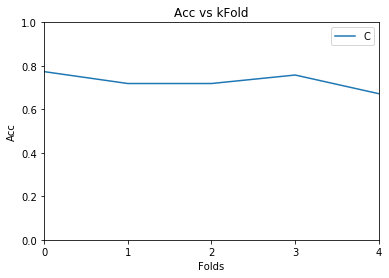

In [41]:
graphic_data([0,1,2,3,4],data,("Conv1D w2v50"),'Acc vs kFold', 'Folds', 'Acc',0,0,4,1)

#### Parte Validación: variando valor de units, w2v50, Conv1D

In [42]:
acc_final_w2v50 = []
score_final_w2v50 = []
history_final_w2v50 = []
models_w2v50 = []
perform_final_validation(Xw2v50, Yw2v50, X_1w2v50, Y_1w2v50, w2v50_emb_size)
score_final_w2v50,acc_final_w2v50,history_final_w2v50,models_w2v50 = perform_final_validation(Xw2v50, Yw2v50,
                                                                                X_1w2v50, Y_1w2v50, w2v50_emb_size,
                                                                                              units_final,epochs,0)

########################
## UNIT SIZE  8
Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_33 (Conv1D)           (None, 36, 8)             408       
_________________________________________________________________
max_pooling1d_33 (MaxPooling (None, 18, 8)             0         
_________________________________________________________________
conv1d_34 (Conv1D)           (None, 18, 8)             72        
_________________________________________________________________
max_pooling1d_34 (MaxPooling (None, 9, 8)              0         
_________________________________________________________________
flatten_17 (Flatten)         (None, 72)                0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 72)                0         
_________________________________________________________________
dense_17 (De

640/640 [==============================] - 0s 108us/step - loss: 0.8462 - accuracy: 0.6375
Epoch 67/200
640/640 [==============================] - 0s 112us/step - loss: 0.8211 - accuracy: 0.6391
Epoch 68/200
640/640 [==============================] - 0s 113us/step - loss: 0.8062 - accuracy: 0.6516
Epoch 69/200
640/640 [==============================] - 0s 97us/step - loss: 0.8009 - accuracy: 0.6594
Epoch 70/200
640/640 [==============================] - 0s 121us/step - loss: 0.7988 - accuracy: 0.6672
Epoch 71/200
640/640 [==============================] - 0s 125us/step - loss: 0.7903 - accuracy: 0.6641
Epoch 72/200
640/640 [==============================] - 0s 107us/step - loss: 0.7817 - accuracy: 0.6734
Epoch 73/200
640/640 [==============================] - 0s 131us/step - loss: 0.7962 - accuracy: 0.6828
Epoch 74/200
640/640 [==============================] - 0s 114us/step - loss: 0.7944 - accuracy: 0.6656
Epoch 75/200
640/640 [==============================] - 0s 102us/step - loss: 

640/640 [==============================] - 0s 137us/step - loss: 0.5725 - accuracy: 0.7688
Epoch 145/200
640/640 [==============================] - 0s 117us/step - loss: 0.5781 - accuracy: 0.7625
Epoch 146/200
640/640 [==============================] - 0s 144us/step - loss: 0.5867 - accuracy: 0.7563
Epoch 147/200
640/640 [==============================] - 0s 113us/step - loss: 0.5639 - accuracy: 0.7734
Epoch 148/200
640/640 [==============================] - 0s 105us/step - loss: 0.5749 - accuracy: 0.7594
Epoch 149/200
640/640 [==============================] - 0s 111us/step - loss: 0.5602 - accuracy: 0.7594
Epoch 150/200
640/640 [==============================] - 0s 104us/step - loss: 0.5873 - accuracy: 0.7719
Epoch 151/200
640/640 [==============================] - 0s 113us/step - loss: 0.5660 - accuracy: 0.7531
Epoch 152/200
640/640 [==============================] - 0s 120us/step - loss: 0.5443 - accuracy: 0.7859
Epoch 153/200
640/640 [==============================] - 0s 106us/ste

640/640 [==============================] - 0s 136us/step - loss: 1.3808 - accuracy: 0.3422
Epoch 9/200
640/640 [==============================] - 0s 131us/step - loss: 1.3567 - accuracy: 0.3531
Epoch 10/200
640/640 [==============================] - 0s 141us/step - loss: 1.3457 - accuracy: 0.3422
Epoch 11/200
640/640 [==============================] - 0s 149us/step - loss: 1.3010 - accuracy: 0.4031
Epoch 12/200
640/640 [==============================] - ETA: 0s - loss: 1.2906 - accuracy: 0.40 - 0s 134us/step - loss: 1.2993 - accuracy: 0.4000
Epoch 13/200
640/640 [==============================] - 0s 152us/step - loss: 1.2777 - accuracy: 0.4000
Epoch 14/200
640/640 [==============================] - 0s 112us/step - loss: 1.2811 - accuracy: 0.3922
Epoch 15/200
640/640 [==============================] - 0s 134us/step - loss: 1.2493 - accuracy: 0.3906
Epoch 16/200
640/640 [==============================] - 0s 156us/step - loss: 1.2391 - accuracy: 0.4484
Epoch 17/200
640/640 [==============

640/640 [==============================] - 0s 165us/step - loss: 0.5453 - accuracy: 0.7859
Epoch 87/200
640/640 [==============================] - 0s 128us/step - loss: 0.5415 - accuracy: 0.7703
Epoch 88/200
640/640 [==============================] - 0s 162us/step - loss: 0.5355 - accuracy: 0.7922
Epoch 89/200
640/640 [==============================] - 0s 146us/step - loss: 0.5072 - accuracy: 0.8156
Epoch 90/200
640/640 [==============================] - 0s 143us/step - loss: 0.5207 - accuracy: 0.7953
Epoch 91/200
640/640 [==============================] - 0s 122us/step - loss: 0.5275 - accuracy: 0.7875
Epoch 92/200
640/640 [==============================] - 0s 139us/step - loss: 0.5184 - accuracy: 0.7906
Epoch 93/200
640/640 [==============================] - 0s 135us/step - loss: 0.5040 - accuracy: 0.7984
Epoch 94/200
640/640 [==============================] - 0s 128us/step - loss: 0.5074 - accuracy: 0.7984
Epoch 95/200
640/640 [==============================] - 0s 128us/step - loss:

640/640 [==============================] - 0s 165us/step - loss: 0.3130 - accuracy: 0.8781
Epoch 165/200
640/640 [==============================] - 0s 134us/step - loss: 0.2945 - accuracy: 0.8938
Epoch 166/200
640/640 [==============================] - 0s 126us/step - loss: 0.3295 - accuracy: 0.8844
Epoch 167/200
640/640 [==============================] - 0s 170us/step - loss: 0.3058 - accuracy: 0.8859
Epoch 168/200
640/640 [==============================] - 0s 139us/step - loss: 0.3065 - accuracy: 0.8953
Epoch 169/200
640/640 [==============================] - 0s 135us/step - loss: 0.2922 - accuracy: 0.9062
Epoch 170/200
640/640 [==============================] - 0s 143us/step - loss: 0.3053 - accuracy: 0.8875
Epoch 171/200
640/640 [==============================] - 0s 151us/step - loss: 0.3327 - accuracy: 0.8766
Epoch 172/200
640/640 [==============================] - 0s 162us/step - loss: 0.3193 - accuracy: 0.8891
Epoch 173/200
640/640 [==============================] - 0s 159us/ste

640/640 [==============================] - 0s 225us/step - loss: 0.6758 - accuracy: 0.7422
Epoch 29/200
640/640 [==============================] - 0s 219us/step - loss: 0.6362 - accuracy: 0.7500
Epoch 30/200
640/640 [==============================] - 0s 204us/step - loss: 0.6421 - accuracy: 0.7375
Epoch 31/200
640/640 [==============================] - 0s 239us/step - loss: 0.6236 - accuracy: 0.7531
Epoch 32/200
640/640 [==============================] - 0s 229us/step - loss: 0.6144 - accuracy: 0.7766
Epoch 33/200
640/640 [==============================] - 0s 198us/step - loss: 0.6081 - accuracy: 0.7516
Epoch 34/200
640/640 [==============================] - 0s 212us/step - loss: 0.5898 - accuracy: 0.7672
Epoch 35/200
640/640 [==============================] - 0s 203us/step - loss: 0.6038 - accuracy: 0.7547
Epoch 36/200
640/640 [==============================] - 0s 222us/step - loss: 0.5841 - accuracy: 0.7781
Epoch 37/200
640/640 [==============================] - 0s 211us/step - loss:

640/640 [==============================] - 0s 176us/step - loss: 0.2197 - accuracy: 0.9250
Epoch 107/200
640/640 [==============================] - 0s 206us/step - loss: 0.2256 - accuracy: 0.9359
Epoch 108/200
640/640 [==============================] - 0s 190us/step - loss: 0.2203 - accuracy: 0.9281
Epoch 109/200
640/640 [==============================] - 0s 186us/step - loss: 0.2258 - accuracy: 0.9281
Epoch 110/200
640/640 [==============================] - 0s 219us/step - loss: 0.2205 - accuracy: 0.9219
Epoch 111/200
640/640 [==============================] - 0s 206us/step - loss: 0.2213 - accuracy: 0.9266
Epoch 112/200
640/640 [==============================] - 0s 187us/step - loss: 0.2153 - accuracy: 0.9359
Epoch 113/200
640/640 [==============================] - 0s 181us/step - loss: 0.2253 - accuracy: 0.9266
Epoch 114/200
640/640 [==============================] - 0s 188us/step - loss: 0.2075 - accuracy: 0.9344
Epoch 115/200
640/640 [==============================] - 0s 187us/ste

640/640 [==============================] - 0s 191us/step - loss: 0.1150 - accuracy: 0.9719
Epoch 185/200
640/640 [==============================] - 0s 198us/step - loss: 0.1234 - accuracy: 0.9656
Epoch 186/200
640/640 [==============================] - 0s 180us/step - loss: 0.1073 - accuracy: 0.9719
Epoch 187/200
640/640 [==============================] - 0s 187us/step - loss: 0.1106 - accuracy: 0.9719
Epoch 188/200
640/640 [==============================] - 0s 172us/step - loss: 0.1189 - accuracy: 0.9641
Epoch 189/200
640/640 [==============================] - 0s 178us/step - loss: 0.1033 - accuracy: 0.9688
Epoch 190/200
640/640 [==============================] - 0s 192us/step - loss: 0.1024 - accuracy: 0.9766
Epoch 191/200
640/640 [==============================] - 0s 174us/step - loss: 0.1187 - accuracy: 0.9578
Epoch 192/200
640/640 [==============================] - 0s 196us/step - loss: 0.1096 - accuracy: 0.9703
Epoch 193/200
640/640 [==============================] - 0s 189us/ste

640/640 [==============================] - 0s 315us/step - loss: 0.2467 - accuracy: 0.9312
Epoch 49/200
640/640 [==============================] - 0s 329us/step - loss: 0.2420 - accuracy: 0.9234
Epoch 50/200
640/640 [==============================] - 0s 268us/step - loss: 0.2454 - accuracy: 0.9344
Epoch 51/200
640/640 [==============================] - 0s 360us/step - loss: 0.2365 - accuracy: 0.9375
Epoch 52/200
640/640 [==============================] - 0s 219us/step - loss: 0.2365 - accuracy: 0.9312
Epoch 53/200
640/640 [==============================] - 0s 222us/step - loss: 0.2323 - accuracy: 0.9281
Epoch 54/200
640/640 [==============================] - 0s 270us/step - loss: 0.2202 - accuracy: 0.9500
Epoch 55/200
640/640 [==============================] - 0s 257us/step - loss: 0.2145 - accuracy: 0.9438
Epoch 56/200
640/640 [==============================] - 0s 256us/step - loss: 0.2016 - accuracy: 0.9500
Epoch 57/200
640/640 [==============================] - 0s 260us/step - loss:

640/640 [==============================] - 0s 421us/step - loss: 0.0569 - accuracy: 0.9922
Epoch 127/200
640/640 [==============================] - 0s 330us/step - loss: 0.0579 - accuracy: 0.9891
Epoch 128/200
640/640 [==============================] - 0s 372us/step - loss: 0.0533 - accuracy: 0.9937
Epoch 129/200
640/640 [==============================] - 0s 374us/step - loss: 0.0528 - accuracy: 0.9891
Epoch 130/200
640/640 [==============================] - 0s 410us/step - loss: 0.0513 - accuracy: 0.9891
Epoch 131/200
640/640 [==============================] - 0s 358us/step - loss: 0.0500 - accuracy: 0.9922
Epoch 132/200
640/640 [==============================] - 0s 372us/step - loss: 0.0436 - accuracy: 0.9937
Epoch 133/200
640/640 [==============================] - 0s 315us/step - loss: 0.0519 - accuracy: 0.9906
Epoch 134/200
640/640 [==============================] - 0s 353us/step - loss: 0.0472 - accuracy: 0.9953
Epoch 135/200
640/640 [==============================] - 0s 315us/ste

Epoch 1/200
640/640 [==============================] - 1s 2ms/step - loss: 1.4384 - accuracy: 0.2859
Epoch 2/200
640/640 [==============================] - 0s 482us/step - loss: 1.2741 - accuracy: 0.4281
Epoch 3/200
640/640 [==============================] - 0s 496us/step - loss: 1.1635 - accuracy: 0.4922
Epoch 4/200
640/640 [==============================] - 0s 511us/step - loss: 1.0513 - accuracy: 0.5609
Epoch 5/200
640/640 [==============================] - 0s 475us/step - loss: 0.9406 - accuracy: 0.6531
Epoch 6/200
640/640 [==============================] - 0s 468us/step - loss: 0.8684 - accuracy: 0.6734
Epoch 7/200
640/640 [==============================] - 0s 543us/step - loss: 0.7964 - accuracy: 0.7141
Epoch 8/200
640/640 [==============================] - 0s 480us/step - loss: 0.7357 - accuracy: 0.7391
Epoch 9/200
640/640 [==============================] - 0s 488us/step - loss: 0.6806 - accuracy: 0.7594
Epoch 10/200
640/640 [==============================] - 0s 503us/step - los

640/640 [==============================] - 0s 673us/step - loss: 0.0300 - accuracy: 0.9969
Epoch 80/200
640/640 [==============================] - 0s 464us/step - loss: 0.0338 - accuracy: 0.9953
Epoch 81/200
640/640 [==============================] - 0s 446us/step - loss: 0.0344 - accuracy: 0.9984
Epoch 82/200
640/640 [==============================] - 0s 447us/step - loss: 0.0301 - accuracy: 0.9984
Epoch 83/200
640/640 [==============================] - 0s 447us/step - loss: 0.0284 - accuracy: 0.9984
Epoch 84/200
640/640 [==============================] - 0s 491us/step - loss: 0.0349 - accuracy: 0.9984
Epoch 85/200
640/640 [==============================] - 0s 493us/step - loss: 0.0283 - accuracy: 1.0000
Epoch 86/200
640/640 [==============================] - 0s 456us/step - loss: 0.0254 - accuracy: 1.0000
Epoch 87/200
640/640 [==============================] - 0s 475us/step - loss: 0.0235 - accuracy: 0.9984
Epoch 88/200
640/640 [==============================] - 0s 525us/step - loss:

640/640 [==============================] - 0s 550us/step - loss: 0.0061 - accuracy: 1.0000
Epoch 158/200
640/640 [==============================] - 0s 405us/step - loss: 0.0047 - accuracy: 1.0000
Epoch 159/200
640/640 [==============================] - 0s 430us/step - loss: 0.0061 - accuracy: 1.0000
Epoch 160/200
640/640 [==============================] - 0s 420us/step - loss: 0.0091 - accuracy: 0.9969
Epoch 161/200
640/640 [==============================] - 0s 418us/step - loss: 0.0072 - accuracy: 1.0000
Epoch 162/200
640/640 [==============================] - 0s 371us/step - loss: 0.0058 - accuracy: 1.0000
Epoch 163/200
640/640 [==============================] - 0s 422us/step - loss: 0.0056 - accuracy: 1.0000
Epoch 164/200
640/640 [==============================] - 0s 470us/step - loss: 0.0066 - accuracy: 0.9984
Epoch 165/200
640/640 [==============================] - 0s 493us/step - loss: 0.0083 - accuracy: 0.9984
Epoch 166/200
640/640 [==============================] - 0s 445us/ste

640/640 [==============================] - 0s 673us/step - loss: 0.2224 - accuracy: 0.9484
Epoch 22/200
640/640 [==============================] - 0s 601us/step - loss: 0.2017 - accuracy: 0.9563
Epoch 23/200
640/640 [==============================] - 0s 605us/step - loss: 0.1931 - accuracy: 0.9469
Epoch 24/200
640/640 [==============================] - 0s 595us/step - loss: 0.1856 - accuracy: 0.9500
Epoch 25/200
640/640 [==============================] - 0s 572us/step - loss: 0.1635 - accuracy: 0.9672
Epoch 26/200
640/640 [==============================] - 0s 576us/step - loss: 0.1592 - accuracy: 0.9656
Epoch 27/200
640/640 [==============================] - 0s 670us/step - loss: 0.1540 - accuracy: 0.9672
Epoch 28/200
640/640 [==============================] - 0s 656us/step - loss: 0.1373 - accuracy: 0.9750
Epoch 29/200
640/640 [==============================] - 0s 628us/step - loss: 0.1345 - accuracy: 0.9672
Epoch 30/200
640/640 [==============================] - 1s 799us/step - loss:

640/640 [==============================] - 1s 905us/step - loss: 0.0076 - accuracy: 1.0000
Epoch 101/200
640/640 [==============================] - 0s 697us/step - loss: 0.0068 - accuracy: 1.0000
Epoch 102/200
640/640 [==============================] - 0s 703us/step - loss: 0.0068 - accuracy: 1.0000
Epoch 103/200
640/640 [==============================] - 0s 745us/step - loss: 0.0061 - accuracy: 1.0000
Epoch 104/200
640/640 [==============================] - 0s 678us/step - loss: 0.0074 - accuracy: 0.9984
Epoch 105/200
640/640 [==============================] - 1s 833us/step - loss: 0.0089 - accuracy: 0.9984
Epoch 106/200
640/640 [==============================] - 1s 828us/step - loss: 0.0084 - accuracy: 1.0000
Epoch 107/200
640/640 [==============================] - 0s 685us/step - loss: 0.0059 - accuracy: 1.0000
Epoch 108/200
640/640 [==============================] - 0s 678us/step - loss: 0.0062 - accuracy: 1.0000
Epoch 109/200
640/640 [==============================] - 0s 706us/ste

640/640 [==============================] - 1s 944us/step - loss: 0.0017 - accuracy: 1.0000
Epoch 179/200
640/640 [==============================] - 0s 706us/step - loss: 0.0017 - accuracy: 1.0000
Epoch 180/200
640/640 [==============================] - 1s 857us/step - loss: 0.0018 - accuracy: 1.0000
Epoch 181/200
640/640 [==============================] - 1s 868us/step - loss: 0.0013 - accuracy: 1.0000
Epoch 182/200
640/640 [==============================] - 0s 704us/step - loss: 0.0014 - accuracy: 1.0000
Epoch 183/200
640/640 [==============================] - 0s 698us/step - loss: 0.0015 - accuracy: 1.0000
Epoch 184/200
640/640 [==============================] - 0s 677us/step - loss: 0.0016 - accuracy: 1.0000
Epoch 185/200
640/640 [==============================] - 0s 690us/step - loss: 0.0013 - accuracy: 1.0000
Epoch 186/200
640/640 [==============================] - 0s 711us/step - loss: 0.0014 - accuracy: 1.0000
Epoch 187/200
640/640 [==============================] - 0s 682us/ste

#### Parte  Gráficos: variando valor de units, w2v50, Conv1D

In [43]:
#Preparando los datos para graficar
data_final_acc_w2v50 = []
data_final_loss_w2v50 = []


for i in np.arange(0,len(units_final)):
    data_final_acc_w2v50.append(history_final_w2v50[i].history['accuracy'])

for i in np.arange(0,len(units_final)):
    data_final_loss_w2v50.append(history_final_w2v50[i].history['loss'])
   

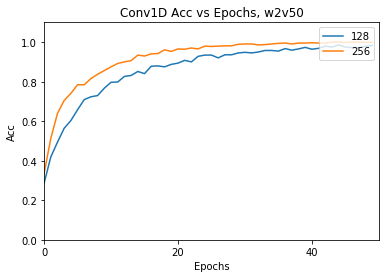

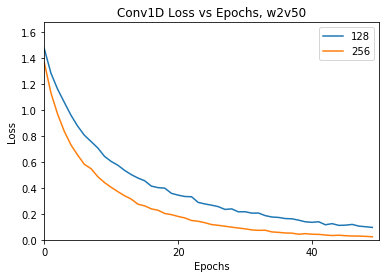

In [44]:
##Gráfico de Accuracy
graphic_data(np.arange(0,epochs,20),data_final_acc_w2v50,units_final,'Conv1D Acc vs Epochs, w2v50', 'Epochs', 'Acc',0,0,epochs,1+0.1)

##Gráfico de Loss 
max_loss_w2v50 = 0
for i in np.arange(0,len(data_final_loss_w2v50)):
    if(max(data_final_loss_w2v50[i]) > max_loss_w2v50):
        max_loss_w2v50 = max(data_final_loss_w2v50[i])
graphic_data(np.arange(0,epochs,20),data_final_loss_w2v50,units_final,'Conv1D Loss vs Epochs, w2v50', 'Epochs', 'Loss',
             0,0,epochs,max_loss_w2v50+0.2)

### Predicción: Modelo w2v50, Conv1D

In [45]:
def predict_all_models(X_real, Y_real, models):
    j = 0
    all_predict = []
    counter_true =  collections.Counter(Y_real.argmax(1))
    for i in units_final:
        print("##### Predict, Units ", i,"#####")
        Y_predict_i=models[j].predict(X_real)
        counter_pred_i = collections.Counter(Y_predict_i.argmax(1))
        all_predict.append(Y_predict_i)
        print("predict: ",list(counter_pred_i.values()))
        print("Real   : ",list(counter_true.values()))
        j = j + 1
    return all_predict

In [46]:
all_predict_w2v50 = []
all_predict_w2v50 = predict_all_models(Xw2v50_full,Yw2v50_full,models_w2v50)

##### Predict, Units  128 #####
predict:  [189, 177, 178, 209]
Real   :  [188, 180, 180, 205]
##### Predict, Units  256 #####
predict:  [187, 174, 184, 208]
Real   :  [188, 180, 180, 205]


In [47]:
i = 0
for j in units_final:
    print("Units:", j, " - RMSE Conv1D w2v50:  ",mean_squared_error(Yw2v50_full, all_predict_w2v50[i])) #Y_true, Y_predict
    i = i + 1

Units: 128  - RMSE Conv1D w2v50:   0.017902318
Units: 256  - RMSE Conv1D w2v50:   0.014332555


#### Matriz Confusión: w2v50

Confusion matrix, without normalization
Confusion matrix, without normalization


<Figure size 360x360 with 0 Axes>

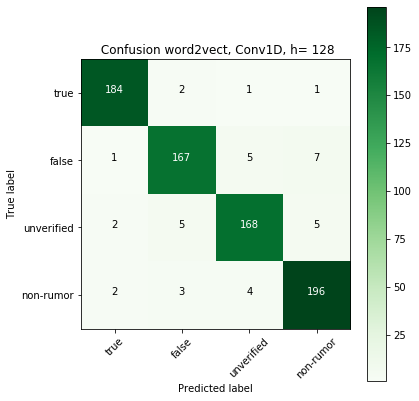

<Figure size 360x360 with 0 Axes>

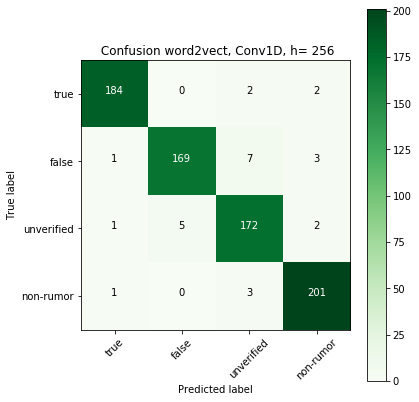

In [48]:
j = 0
for i in units_final:
    plot_conf_matrix(Yw2v50_full, all_predict_w2v50[j]," Confusion word2vect, Conv1D, h= " + str(i))
    j = j +1